In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# the following line only works in an IPython notebook
%matplotlib notebook

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from skimage import filters
from skimage import feature

In [19]:
import numpy as np

def p2(binary_in):
    
    #new labels
    labels=np.zeros(binary_in.shape)
    next_label=100
    
    #parent, rank for union find operations
    parent = {}
    rank = {}

    
    #define union find operations for resolving equivalences
    def find(p):
        if p != parent[p]:
            parent[p] = find(parent[p])
        return parent[p]
    
    def union(p, q):
        root_p = find(p)
        root_q = find(q)
        if root_p != root_q:
            if rank[root_p] < rank[root_q]:
                parent[root_p] = root_q
            elif rank[root_p] > rank[root_q]:
                parent[root_q] = root_p
            else:
                parent[root_q] = root_p
                rank[root_p] += 1

    #first pass of labeling
    for (x,y), value in np.ndenumerate(binary_in):
        if value == 0:
            #background
            labels[x,y] = 0
        else:
            try:
                #upperleft, left, and upper
                neighbors = [binary_in.item((x-1,y-1)), binary_in.item((x-1, y)), binary_in.item((x, y-1))]
                #convert into 1s and 0s for easier comparison later
                neighbors = [int(neighbors[i] != 0) for i in range(len(neighbors))]
                
                #labels of neighbors
                labels_n = [labels[x-1, y-1], labels[x-1,y], labels[x, y-1]]
                labels_n = list(map(int, labels_n))
                #Upleft, left, up
                
                if neighbors == [0,0,0]:
                    #new label
                    labels[x,y] = next_label
                    parent[next_label] = next_label
                    rank[next_label] = 0
                    next_label += 1
                elif neighbors[0] != 0:
                    #if upper left is not background, set label to that.
                    labels[x,y] = labels_n[0]
                elif neighbors == [0, 1, 0]:
                    #if left is the only nonbackground, set equal to that.
                    labels[x,y] = labels_n[1]
                elif neighbors == [0, 0, 1]:
                    #if up is the only nonbackground, set equal to that.
                    labels[x,y] = labels_n[2]
                else:
                    #if left and up are both nonbackground and upper left is background
                    if labels_n[1] != labels_n[2]:
                    #if left and up have different labels, set equivalence of labels
                        union(labels_n[1], labels_n[2])
                    #set label equal to either of them.
                    labels[x,y] = labels_n[2]
                    
            except IndexError:
                #you're on the edge..??? set equal to 0 for now...
                labels[x,y] = 0
        
        
    #second pass to relabel objects to numbers you can actually see
    #and to resolve equivalences in union find
    
    #determine new labels
    old_labels = list(set(parent.values()))
    #new_labels = np.linspace(200, 255, len(set(parent.values()))) 
    
    #relabel everything
    for (x,y), label in np.ndenumerate(labels):
        label = int(label)
        if label in parent.keys() and parent[label] in old_labels:
            l = find(label)
            #new_l = new_labels[old_labels.index(l)]
            labels[x,y] = l  
            
    return labels

#input is nparray
def p3(labeled_image): #return [database, output_image]
    
    labels = np.delete(np.unique(labeled_image),0)
    areas = centerx = centery = np.array([])
    #centerx is numerator of center_x
    #centery is numerator of center_y
    
    #calculate center and area first in order to get center of mass
    for label in labels:
        if label%100==0: print(label)
        area = cen_x = cen_y = 0
        for (x,y), value in np.ndenumerate(labeled_image):
            if value == label:
                area += 1
                cen_x += x
                cen_y += y
        areas = np.append(areas, area)
        centerx = np.append(centerx, cen_x)
        centery = np.append(centery, cen_y)
    centerx = np.divide(centerx, areas)
    centery = np.divide(centery, areas)
    position = np.vstack((centerx, centery))
    
    #need center of mass to
    #calculate a,b,c
    arr_a = arr_b = arr_c = np.array([])
    for i in range(len(labels)):
        a = b = c = 0
        for (x,y), value in np.ndenumerate(labeled_image):
            if value == labels[i]:
                xbar = x - centerx[i]
                ybar = y - centery[i]
                a += ybar * ybar
                b += 2 * xbar * ybar
                c += xbar * xbar
        arr_a = np.append(arr_a, a)
        arr_b = np.append(arr_b, b)
        arr_c = np.append(arr_c, c)
    orientation = 0.5 * np.arctan2(arr_b, np.subtract(arr_a, arr_c))

    #find roundnesses
    #trust me this works it's just really ugly    
    roundness_numerator   = np.add(np.subtract(np.multiply(arr_a, np.square(np.sin(orientation))), np.multiply(arr_b, np.multiply(np.sin(orientation), np.cos(orientation)))), np.multiply(arr_c, np.square(np.cos(orientation))))
    roundness_denominator = np.add(np.subtract(np.multiply(arr_a, np.square(np.sin(np.add(orientation, np.pi/2)))), np.multiply(arr_b, np.multiply(np.sin(np.add(orientation, np.pi/2)), np.cos(np.add(orientation, np.pi/2))))),np.multiply(arr_c, np.square(np.cos(np.add(orientation, np.pi/2)))))    
    roundness = np.divide(roundness_numerator, roundness_denominator)
    
    database = {}    
    for i in range(len(labels)):
        if i%100==0: print(i)
        database[labels[i]] = {'position':(position[1][i], position[0][i]), 'orientation':orientation[i], 'area':areas[i], 'roundness':roundness[i]}
        
    return database


In [4]:
frames = pims.ImageSequence('../data/huganir/tp*_results0001.tif', as_grey=True)

In [5]:
tp1 = pims.open('../data/R04_t001.tif')
background1 = tp1[1].clip(-2500, 10000)

tp2 = pims.open('../data/R04_t002.tif')
background2 = tp2[1].clip(-2500, 10000)

tp3 = pims.open('../data/R04_t003.tif')
background3 = tp3[1].clip(-2500, 10000)

tp4 = pims.open('../data/R04_t004.tif')
background4 = tp4[1].clip(-2500, 10000)

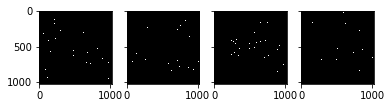

In [6]:
thresh0 = filters.threshold_otsu(frames[0])
thresh1 = filters.threshold_otsu(frames[1])
thresh2 = filters.threshold_otsu(frames[2])
thresh3 = filters.threshold_otsu(frames[3])

threshim0 = np.array(frames[0]) > thresh0
threshim1 = np.array(frames[1]) > thresh1
threshim2 = np.array(frames[2]) > thresh2
threshim3 = np.array(frames[3]) > thresh3

fig, axes = plt.subplots(1, 4, sharey=True)
axes[0].imshow(threshim0)
axes[1].imshow(threshim1)
axes[2].imshow(threshim2)
axes[3].imshow(threshim3)

In [7]:
f = tp.locate(frames[1], 7)
#detect features

In [8]:
f.head(10)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
1,9.000000,902.000000,867.621009,1.025227,0.299290,199.855670,1438.0,0.0,1
2,11.448216,474.000000,3535.703985,1.344999,0.049888,530.738222,7195.0,0.0,1
3,13.788933,864.562931,5854.338465,1.573161,0.167871,631.676966,12960.0,0.0,1
4,14.999900,550.000000,870.229807,1.025786,0.298987,200.333950,1441.0,0.0,1
5,16.000000,251.000000,871.121146,1.025894,0.298950,200.486129,1442.0,0.0,1
6,18.000000,65.000000,872.838605,1.026244,0.298816,200.812229,1444.0,0.0,1
7,17.995435,228.000273,876.208302,1.029211,0.294932,201.007889,1455.0,0.0,1
8,18.000000,572.000000,874.556063,1.026544,0.298683,201.138329,1446.0,0.0,1
9,20.231898,265.286967,2996.748050,1.275611,0.365140,477.366562,5788.0,0.0,1
10,20.000000,723.000000,876.251782,1.026856,0.298518,201.442689,1448.0,0.0,1


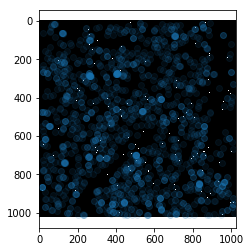

In [9]:
results = feature.peak_local_max(frames[1], min_distance=10)

plt.figure()
plt.imshow(threshim1)
plt.scatter(results[...,0], results[...,1], alpha=0.1)

In [10]:
labels = p2(frames[1])

In [21]:
database = p3(labels)

100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0
1100.0
1300.0
1400.0
1600.0
1700.0
1800.0
1900.0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


/home/dli/anaconda2/envs/lids/lib/python3.6/site-packages/ipykernel/__main__.py:139: RuntimeWarning: invalid value encountered in true_divide


In [1]:
bloblog1 = feature.blob_log(threshim1)

NameError: name 'feature' is not defined

In [30]:
print(bloblog1[:, :2])

[[1015.  550.]
 [1015.  477.]
 [1015.  458.]
 ...
 [  12.  474.]
 [   9.  902.]
 [   9.  551.]]


In [31]:
bloblog2 = feature.blob_log(threshim2)

In [32]:
print(bloblog2[:, :2])

[[1008.  460.]
 [1004.  935.]
 [1002.  937.]
 ...
 [  11.  964.]
 [  10.  454.]
 [   8.  893.]]


In [ ]:
print(database)